# ML/AI Model

In [17]:
#%pip install --upgrade numpy
#%pip install --upgrade pandas
#%pip install --upgrade matplotlib
#%pip install --upgrade scikit-learn
#%pip install --upgrade imbalanced-learn

In [18]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler #, Normalizer, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.naive_bayes import ComplementNB #GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
# https://medium.com/analytics-vidhya/the-effect-of-data-normalization-in-your-models-should-we-use-a-pipeline-6b97510f1908
# from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score

## Load data

In [19]:
# Load data
df = pd.read_csv('./data/data.csv', index_col='ticker')

In [20]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1:].to_numpy().ravel()
print(len(X), len(y))

2552 2552


## Dealing with dataset imbalance

In [21]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Under-sampling
#sampler = RandomUnderSampler(random_state=42)

# Over-sampling
#sampler = ADASYN(random_state=42)
sampler = SMOTE(random_state=42)

X_resampled, y_resampled = sampler.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
print(len(X_resampled), len(y_resampled))

[(1.0, 1504), (2.0, 1504), (3.0, 1504), (4.0, 1504), (5.0, 1504)]
7520 7520


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(1.0, 1203), (2.0, 1204), (3.0, 1203), (4.0, 1203), (5.0, 1203)]
[(1.0, 301), (2.0, 300), (3.0, 301), (4.0, 301), (5.0, 301)]


## Choose Model

### Simple test

In [23]:
scaler = MinMaxScaler()
scaler = scaler.fit(X)
X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

#ml = SVC()
ml = KNeighborsClassifier(n_neighbors=5)
clf = ml.fit(X_train_t, y_train)
y_pred = clf.predict(X_test_t)
print(accuracy_score(y_test, y_pred))

0.7732712765957447


### Grid Search

See:
- https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
- https://machinelearningmastery.com/principal-components-analysis-for-dimensionality-reduction-in-python/

In [24]:
names = [
    "Nearest Neighbors",
    "Naive Bayes",
    "Linear SVM",
    "Other SVM",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Ada Boost",
    "QDM",
    "Multilayer Perceptron"
]

classifiers = [
    KNeighborsClassifier(),
    ComplementNB(), #GaussianNB, MultinomialNB
    LinearSVC(dual=True, max_iter=1000, random_state=42),
    SVC(random_state=42),
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(early_stopping=True, max_iter=500, random_state=42)
]

parameters = [
    { 'clf__n_neighbors': [5], 'clf__p': [1, 2] }, #KNeighborsClassifier
    { 'clf__alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5] }, #ComplementNB(), #GaussianNB, MultinomialNB
    { 'clf__C': np.logspace(-5, 1, 5) }, #LinearSVC
    { 'clf__C': np.logspace(-5, 1, 5), 'clf__kernel': ['poly', 'rbf', 'sigmoid', 'precomputed'] }, #SVC
    { 'clf__C': np.logspace(-5, 1, 5), 'clf__max_iter': [200, 300], 'clf__penalty': ['l1', 'l2', 'elasticnet'] }, #LogisticRegression
    { 'clf__max_depth': [1, 2, 3, 4, 5], 'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True) }, #DecisionTreeClassifier
    { 'clf__max_depth': [1, 2, 3, 4, 5], 'clf__min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True) }, #RandomForestClassifier
    { 'clf__n_estimators': [10, 50, 100, 500] }, #AdaBoostClassifier
    { }, #QuadraticDiscriminantAnalysis
    { 'clf__activation': ['identity', 'logistic', 'tanh', 'relu'], 'clf__alpha': [1e-2, 1e-3, 1e-4, 1e-5], 'clf__hidden_layer_sizes': [(25, 10), (10, 10), (10, 5), (80, 20, 5)], 'clf__learning_rate': ['constant', 'invscaling', 'adaptive'], 'clf__solver': ['lbfgs', 'sgd', 'adam'] } #MLPClassifier
]

for name, classifier, params in zip(names, classifiers, parameters):
    pipe = Pipeline([
        # Adding PCA to the pipeline yields no improvement
        # ('std', StandardScaler()),
        # ('pca', PCA(n_components=11)),
        ('mms', MinMaxScaler()),
        ('clf', classifier),
    ])
    gs = GridSearchCV(pipe, param_grid=params, cv=8, n_jobs=-1, verbose=0)
    clf = gs.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("{} score: {}".format(name, score))
    print(gs.best_params_)
    print(gs.best_score_)

Nearest Neighbors score: 0.7792553191489362
{'clf__n_neighbors': 5, 'clf__p': 1}
0.7599734042553192
Naive Bayes score: 0.2752659574468085
{'clf__alpha': 0.1}
0.2742686170212766


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/sit

Linear SVM score: 0.3178191489361702
{'clf__C': 0.31622776601683794}
0.31964760638297873


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 420, in fit
    se

Other SVM score: 0.45345744680851063
{'clf__C': 10.0, 'clf__kernel': 'poly'}
0.46808510638297873


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Logistic Regression score: 0.32180851063829785
{'clf__C': 10.0, 'clf__max_iter': 300, 'clf__penalty': 'l2'}
0.3228058510638298
Decision Tree score: 0.3404255319148936
{'clf__max_depth': 5, 'clf__min_samples_split': 0.1}
0.3395944148936171
Random Forest score: 0.3929521276595745
{'clf__max_depth': 5, 'clf__min_samples_split': 0.1}
0.3887965425531915
Ada Boost score: 0.418218085106383
{'clf__n_estimators': 500}
0.4004321808510638
QDM score: 0.37566489361702127
{}
0.3751662234042553


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs

Multilayer Perceptron score: 0.4128989361702128
{'clf__activation': 'tanh', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (80, 20, 5), 'clf__learning_rate': 'constant', 'clf__solver': 'lbfgs'}
0.4360039893617021


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Optimise Selected Model

Although the score is quite low and DecisionTree is slightly better on test accuracy (but not on train accuracy), I have decided to use Bayesian Optimisation to optimise MLPClassifier, because there are more parameters to hypertune. 

In [25]:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_train_t = scaler.transform(X_train)
    X_test_t = scaler.transform(X_test)
    print(len(X_train_t), len(X_test_t))

6016 1504


### Blackbox function to optimise

In [26]:
activations = ['identity', 'logistic', 'tanh', 'relu']
learning_rates = ['constant', 'invscaling', 'adaptive']
solvers = ['lbfgs', 'sgd', 'adam']

In [27]:
def convert(x1, x2, x3, x4, x5, x6):
    activation = activations[int(round(x1*(len(activations)-1)))]
    print('activation', activation)
    alpha = x2
    print('alpha', alpha)
    hidden_layer_sizes = (5+int(100*x3), 5+int(100*x4))
    print('hidden_layer_sizes', hidden_layer_sizes)
    learning_rate = learning_rates[int(round(x5*(len(learning_rates)-1)))]
    print('learning_rate', learning_rate)
    solver = solvers[int(round(x6*(len(solvers)-1)))]
    print('learning_rate', solver)
    return activation, alpha, hidden_layer_sizes, learning_rate, solver

In [28]:
# blackbox function to optimise
def score(x1, x2, x3, x4, x5, x6):
    activation, alpha, hidden_layer_sizes, learning_rate, solver = convert(x1, x2, x3, x4, x5, x6)
    ml = MLPClassifier(
        activation = activation,
        alpha = alpha,
        early_stopping = True,
        hidden_layer_sizes = hidden_layer_sizes,
        learning_rate = learning_rate,
        max_iter = 1000,
        # momentum
        random_state = 42,
        solver = solver
    )
    clf = ml.fit(X_train_t, y_train)
    y_pred = clf.predict(X_test_t)
    return accuracy_score(y_test, y_pred)

### Bayesian optimisation

In [29]:
from util import ucb, ei, poi

# Build a gridsearch
x1 = np.linspace(0, 1, len(activations)) # activation
x2 = np.logspace(-5, 1, 5) # alpha
x3 = np.linspace(0, 1, 100) # hidden_layer_sizes (x3,)
x4 = np.linspace(0, 1, 100) # hidden_layer_sizes (, x4)
x5 = np.linspace(0, 1, len(learning_rates)) # learning_rate
x6 = np.linspace(0, 1, len(solvers)) # solver
X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        for k in range(len(x3)):
            for l in range(len(x4)):
                for m in range(len(x5)):
                    for n in range(len(x6)):
                        #for o in range(len(x7)):
                        #for p in range(len(x8)):
                        #X_grid.append([x1[i], x2[j], x3[k], x4[l], x5[m], x6[n], x7[o], x8[p]])
                        X_grid.append([x1[i], x2[j], x3[k], x4[l], x5[m], x6[n]])
X_grid = np.array(X_grid)

id_max = 0
X_max = X_grid[int(len(X_grid)/2)]
X_params = [X_max]
y_max = score(*X_max)
y_params = [y_max]

N=100
for i in range(1, N):
    kernel = Matern(length_scale=1, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=2, random_state=42)

    # Fit the model 
    gpr.fit(X_params, y_params)

    # Make predictions over the grid to maximise the acquisition function
    mean, std = gpr.predict(X_grid, return_std = True)
    # y_max = np.max(y_params)
    #xi = 10 if i < 2*N/3 else 0.1 #ucb
    #acq = ucb(mean, std, xi)
    xi = 0.2 if i < 2*N/3 else 0.01 #ei, poi
    #acq = ei(mean, std, y_max, xi)
    acq = poi(mean, std, y_max, xi)
    id_max_acq = np.argmax(acq)
    next_X = X_grid[id_max_acq]
    next_y = score(*next_X)    
    X_params.append(next_X)
    y_params.append(next_y)
    id_max = np.argmax(y_params)
    X_max = X_params[id_max]
    y_max = y_params[id_max]
    print(i, 'Global maximum           :', '-'.join(format(x, "0.6f") for x in X_max), 'score:', y_max)
    print(i, 'Next observation to probe:', '-'.join(format(x, "0.6f") for x in next_X))

# Best
print('Best score', y_max)
convert(*X_max)

activation tanh
alpha 1e-05
hidden_layer_sizes (5, 5)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


activation identity
alpha 0.00031622776601683794
hidden_layer_sizes (13, 45)
learning_rate constant
learning_rate lbfgs
1 Global maximum           : 0.666667-0.000010-0.000000-0.000000-0.000000-0.000000 score: 0.37898936170212766
1 Next observation to probe: 0.000000-0.000316-0.080808-0.404040-0.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (5, 5)
learning_rate adaptive
learning_rate adam
2 Global maximum           : 0.666667-0.000010-0.000000-0.000000-0.000000-0.000000 score: 0.37898936170212766
2 Next observation to probe: 1.000000-10.000000-0.000000-0.000000-1.000000-1.000000
activation relu
alpha 1e-05
hidden_layer_sizes (105, 5)
learning_rate adaptive
learning_rate adam
3 Global maximum           : 0.666667-0.000010-0.000000-0.000000-0.000000-0.000000 score: 0.37898936170212766
3 Next observation to probe: 1.000000-0.000010-1.000000-0.000000-1.000000-1.000000
activation relu
alpha 1e-05
hidden_layer_sizes (5, 105)
learning_rate constant
learning_rate adam
4 Global 

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
5 Next observation to probe: 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate lbfgs
6 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
6 Next observation to probe: 0.000000-10.000000-1.000000-0.000000-0.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
7 Next observation to probe: 1.000000-0.316228-1.000000-1.000000-1.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
8 Next observation to probe: 1.000000-0.316228-1.000000-0.000000-0.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate lbfgs
9 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
9 Next observation to probe: 0.000000-10.000000-1.000000-1.000000-1.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (5, 105)
learning_rate constant
learning_rate lbfgs
10 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
10 Next observation to probe: 0.000000-10.000000-0.000000-1.000000-0.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate adam
11 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


13 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
13 Next observation to probe: 1.000000-0.000010-1.000000-1.000000-0.000000-0.000000
activation identity
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate adam
14 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
14 Next observation to probe: 0.000000-0.316228-1.000000-1.000000-1.000000-1.000000
activation identity
alpha 1e-05
hidden_layer_sizes (105, 5)
learning_rate adaptive
learning_rate lbfgs
15 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
15 Next observation to probe: 0.000000-0.000010-1.000000-0.000000-1.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (5, 5)
learning_rate constant
learning_rate lbfgs
16 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.4

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


19 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
19 Next observation to probe: 1.000000-10.000000-1.000000-0.000000-1.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (5, 105)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


20 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
20 Next observation to probe: 1.000000-10.000000-0.000000-1.000000-1.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (5, 5)
learning_rate adaptive
learning_rate lbfgs
21 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
21 Next observation to probe: 0.000000-10.000000-0.000000-0.000000-1.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate adam
22 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
22 Next observation to probe: 1.000000-0.316228-1.000000-1.000000-0.000000-1.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (5, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


23 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
23 Next observation to probe: 1.000000-0.316228-0.000000-1.000000-0.000000-0.000000
activation identity
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate lbfgs
24 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
24 Next observation to probe: 0.000000-0.316228-1.000000-1.000000-0.000000-0.000000
activation identity
alpha 1e-05
hidden_layer_sizes (5, 105)
learning_rate adaptive
learning_rate lbfgs
25 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
25 Next observation to probe: 0.000000-0.000010-0.000000-1.000000-1.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate adam
26 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


37 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
37 Next observation to probe: 1.000000-0.000010-1.000000-0.000000-1.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


38 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
38 Next observation to probe: 1.000000-10.000000-1.000000-1.000000-1.000000-0.000000
activation tanh
alpha 10.0
hidden_layer_sizes (70, 64)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


39 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
39 Next observation to probe: 0.666667-10.000000-0.656566-0.595960-0.500000-0.000000
activation identity
alpha 1e-05
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate lbfgs
40 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
40 Next observation to probe: 0.000000-0.000010-1.000000-0.000000-0.000000-0.000000
activation relu
alpha 1e-05
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate adam
41 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
41 Next observation to probe: 1.000000-0.000010-1.000000-1.000000-1.000000-1.000000
activation identity
alpha 1e-05
hidden_layer_sizes (5, 5)
learning_rate constant
learning_rate adam
42 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


44 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
44 Next observation to probe: 1.000000-0.000010-0.000000-1.000000-1.000000-0.000000
activation relu
alpha 1e-05
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate adam
45 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
45 Next observation to probe: 1.000000-0.000010-1.000000-0.000000-0.000000-1.000000
activation identity
alpha 1e-05
hidden_layer_sizes (5, 105)
learning_rate adaptive
learning_rate adam
46 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
46 Next observation to probe: 0.000000-0.000010-0.000000-1.000000-1.000000-1.000000
activation identity
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate lbfgs
47 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


50 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
50 Next observation to probe: 1.000000-10.000000-1.000000-0.000000-0.000000-0.000000
activation identity
alpha 1e-05
hidden_layer_sizes (5, 105)
learning_rate constant
learning_rate lbfgs
51 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
51 Next observation to probe: 0.000000-0.000010-0.000000-1.000000-0.000000-0.000000
activation identity
alpha 1e-05
hidden_layer_sizes (5, 5)
learning_rate adaptive
learning_rate lbfgs
52 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
52 Next observation to probe: 0.000000-0.000010-0.000000-0.000000-1.000000-0.000000
activation relu
alpha 1e-05
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


53 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
53 Next observation to probe: 1.000000-0.000010-1.000000-0.000000-0.000000-0.000000
activation identity
alpha 1e-05
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate adam
54 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
54 Next observation to probe: 0.000000-0.000010-1.000000-1.000000-0.000000-1.000000
activation identity
alpha 10.0
hidden_layer_sizes (5, 105)
learning_rate adaptive
learning_rate lbfgs
55 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
55 Next observation to probe: 0.000000-10.000000-0.000000-1.000000-1.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (5, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


56 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
56 Next observation to probe: 1.000000-10.000000-0.000000-1.000000-0.000000-0.000000
activation relu
alpha 1e-05
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


57 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
57 Next observation to probe: 1.000000-0.000010-1.000000-1.000000-1.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate sgd
58 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
58 Next observation to probe: 1.000000-10.000000-1.000000-1.000000-0.000000-0.500000
activation identity
alpha 10.0
hidden_layer_sizes (5, 105)
learning_rate constant
learning_rate adam
59 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
59 Next observation to probe: 0.000000-10.000000-0.000000-1.000000-0.000000-1.000000
activation identity
alpha 10.0
hidden_layer_sizes (105, 5)
learning_rate constant
learning_rate adam
60 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.4268617021276595

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


61 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
61 Next observation to probe: 0.666667-0.316228-1.000000-0.000000-1.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 5)
learning_rate adaptive
learning_rate sgd
62 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
62 Next observation to probe: 1.000000-0.316228-1.000000-0.000000-1.000000-0.500000
activation logistic
alpha 0.31622776601683794
hidden_layer_sizes (50, 105)
learning_rate adaptive
learning_rate lbfgs
63 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
63 Next observation to probe: 0.333333-0.316228-0.454545-1.000000-1.000000-0.000000
activation relu
alpha 1e-05
hidden_layer_sizes (5, 5)
learning_rate adaptive
learning_rate adam
64 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 sc

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


65 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
65 Next observation to probe: 1.000000-0.316228-1.000000-0.515152-0.500000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 5)
learning_rate adaptive
learning_rate adam
66 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
66 Next observation to probe: 1.000000-10.000000-1.000000-0.000000-1.000000-1.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


67 Global maximum           : 1.000000-10.000000-1.000000-1.000000-0.000000-0.000000 score: 0.42686170212765956
67 Next observation to probe: 1.000000-10.000000-1.000000-1.000000-0.500000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 66)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


68 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
68 Next observation to probe: 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


69 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
69 Next observation to probe: 1.000000-0.316228-1.000000-1.000000-0.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 74)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


70 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
70 Next observation to probe: 1.000000-10.000000-1.000000-0.696970-1.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 58)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


71 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
71 Next observation to probe: 1.000000-0.316228-1.000000-0.535354-0.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


72 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
72 Next observation to probe: 1.000000-10.000000-1.000000-1.000000-1.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 60)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


73 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
73 Next observation to probe: 1.000000-0.316228-1.000000-0.555556-1.000000-0.000000
activation relu
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


74 Global maximum           : 1.000000-0.316228-1.000000-0.616162-0.000000-0.000000 score: 0.43018617021276595
74 Next observation to probe: 1.000000-0.316228-1.000000-1.000000-0.500000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 27)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


75 Global maximum           : 0.666667-0.316228-1.000000-0.222222-0.000000-0.000000 score: 0.5605053191489362
75 Next observation to probe: 0.666667-0.316228-1.000000-0.222222-0.000000-0.000000
activation logistic
alpha 0.31622776601683794
hidden_layer_sizes (105, 25)
learning_rate constant
learning_rate lbfgs
76 Global maximum           : 0.666667-0.316228-1.000000-0.222222-0.000000-0.000000 score: 0.5605053191489362
76 Next observation to probe: 0.333333-0.316228-1.000000-0.202020-0.000000-0.000000
activation tanh
alpha 1e-05
hidden_layer_sizes (105, 20)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


77 Global maximum           : 0.666667-0.316228-1.000000-0.222222-0.000000-0.000000 score: 0.5605053191489362
77 Next observation to probe: 0.666667-0.000010-1.000000-0.151515-0.000000-0.000000
activation tanh
alpha 0.01
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


78 Global maximum           : 0.666667-0.010000-1.000000-1.000000-0.000000-0.000000 score: 0.6050531914893617
78 Next observation to probe: 0.666667-0.010000-1.000000-1.000000-0.000000-0.000000
activation logistic
alpha 1e-05
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate lbfgs
79 Global maximum           : 0.666667-0.010000-1.000000-1.000000-0.000000-0.000000 score: 0.6050531914893617
79 Next observation to probe: 0.333333-0.000010-1.000000-1.000000-0.000000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


80 Global maximum           : 0.666667-0.316228-1.000000-1.000000-0.000000-0.000000 score: 0.625
80 Next observation to probe: 0.666667-0.316228-1.000000-1.000000-0.000000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (92, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


81 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
81 Next observation to probe: 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (79, 105)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


82 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
82 Next observation to probe: 0.666667-0.316228-0.747475-1.000000-0.000000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (103, 90)
learning_rate constant
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


83 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
83 Next observation to probe: 0.666667-0.316228-0.989899-0.858586-0.000000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate constant
learning_rate sgd
84 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
84 Next observation to probe: 0.666667-0.316228-1.000000-1.000000-0.000000-0.500000
activation tanh
alpha 1e-05
hidden_layer_sizes (105, 5)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


85 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
85 Next observation to probe: 0.666667-0.000010-1.000000-0.000000-0.500000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 105)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


86 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
86 Next observation to probe: 0.666667-0.316228-1.000000-1.000000-0.500000-0.000000
activation tanh
alpha 0.01
hidden_layer_sizes (105, 105)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


87 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
87 Next observation to probe: 0.666667-0.010000-1.000000-1.000000-0.500000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (5, 5)
learning_rate adaptive
learning_rate lbfgs
88 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
88 Next observation to probe: 1.000000-10.000000-0.000000-0.000000-1.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (5, 5)
learning_rate constant
learning_rate lbfgs
89 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
89 Next observation to probe: 0.000000-10.000000-0.000000-0.000000-0.000000-0.000000
activation relu
alpha 10.0
hidden_layer_sizes (5, 105)
learning_rate adaptive
learning_rate adam
90 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
90 Next obser

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


91 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
91 Next observation to probe: 0.666667-0.000010-0.656566-0.000000-0.000000-0.000000
activation identity
alpha 10.0
hidden_layer_sizes (105, 105)
learning_rate adaptive
learning_rate adam
92 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
92 Next observation to probe: 0.000000-10.000000-1.000000-1.000000-1.000000-1.000000
activation tanh
alpha 0.01
hidden_layer_sizes (105, 79)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


93 Global maximum           : 0.666667-0.316228-0.878788-1.000000-0.000000-0.000000 score: 0.6382978723404256
93 Next observation to probe: 0.666667-0.010000-1.000000-0.747475-0.500000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 86)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


94 Global maximum           : 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000 score: 0.6462765957446809
94 Next observation to probe: 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 77)
learning_rate invscaling
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


95 Global maximum           : 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000 score: 0.6462765957446809
95 Next observation to probe: 0.666667-0.316228-1.000000-0.727273-0.500000-0.000000
activation tanh
alpha 1e-05
hidden_layer_sizes (105, 73)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


96 Global maximum           : 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000 score: 0.6462765957446809
96 Next observation to probe: 0.666667-0.000010-1.000000-0.686869-1.000000-0.000000
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 91)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


97 Global maximum           : 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000 score: 0.6462765957446809
97 Next observation to probe: 0.666667-0.316228-1.000000-0.868687-1.000000-0.000000
activation tanh
alpha 0.01
hidden_layer_sizes (105, 96)
learning_rate adaptive
learning_rate lbfgs


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


98 Global maximum           : 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000 score: 0.6462765957446809
98 Next observation to probe: 0.666667-0.010000-1.000000-0.919192-1.000000-0.000000
activation logistic
alpha 1e-05
hidden_layer_sizes (105, 51)
learning_rate adaptive
learning_rate adam
99 Global maximum           : 0.666667-0.316228-1.000000-0.818182-0.500000-0.000000 score: 0.6462765957446809
99 Next observation to probe: 0.333333-0.000010-1.000000-0.464646-1.000000-1.000000
Best score 0.6462765957446809
activation tanh
alpha 0.31622776601683794
hidden_layer_sizes (105, 86)
learning_rate invscaling
learning_rate lbfgs


('tanh', 0.31622776601683794, (105, 86), 'invscaling', 'lbfgs')

### Plot convergence

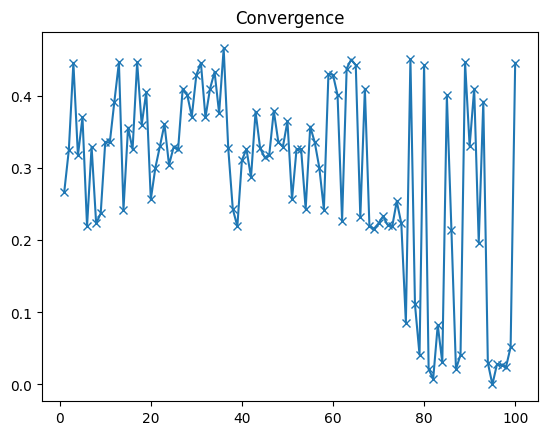

In [30]:
from util import plot_convergence
plot_convergence(y_params, 0)